In [1]:
import os
%pwd

'f:\\work env\\End-to-End-MLOps-with-MLflow\\research'

In [2]:
os.chdir('../')

In [3]:
%pwd

'f:\\work env\\End-to-End-MLOps-with-MLflow'

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('artifacts/data_ingestion/bank-full.csv', sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## EDA

In [8]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64


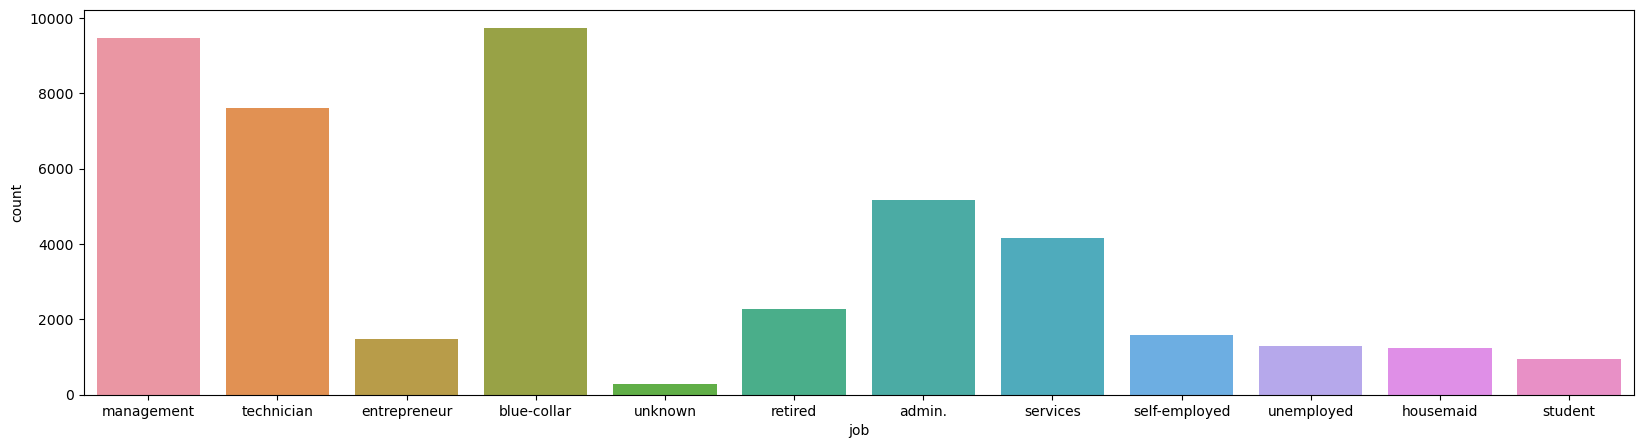

In [15]:
print(df['job'].value_counts())
plt.figure(figsize=(20, 5))
sns.countplot(x='job', data=df)
plt.show()

no     37967
yes     7244
Name: loan, dtype: int64


<Axes: ylabel='loan'>

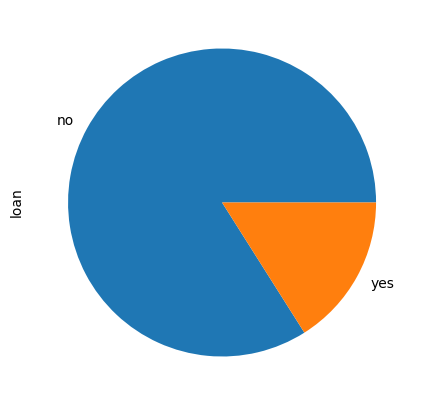

In [20]:
print(df.loan.value_counts())
plt.figure(figsize=(20, 5))
df.loan.value_counts().plot(kind='pie')


yes    25130
no     20081
Name: housing, dtype: int64


<Axes: ylabel='housing'>

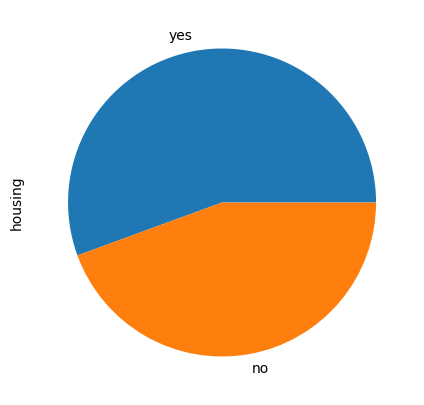

In [22]:
print(df.housing.value_counts())
plt.figure(figsize=(20, 5))
df.housing.value_counts().plot(kind='pie')

In [27]:
# Percentage of each category that we will predict
df.y.value_counts().apply(lambda x: x/df.shape[0]*100)

no     88.30152
yes    11.69848
Name: y, dtype: float64

In [33]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataValidationConfig:
  root_dir: Path
  unzip_data_dir: Path
  STATUS_FILE: str 
  all_schema: dict

In [34]:
from MLOpsProject.constants import *
from MLOpsProject.utils.common import read_yaml, create_directories

In [61]:
# creating folders from the config file
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_validation_config(self) -> DataValidationConfig:
        config = self.config.data_validation
        schema = self.schema.COLUMNS

        create_directories([config.root_dir])

        data_validation_config = DataValidationConfig(
            unzip_data_dir=config.unzip_data_dir,
            root_dir=config.root_dir,
            STATUS_FILE=config.STATUS_FILE,
            all_schema=schema,
        )

        return data_validation_config

In [62]:
dt = read_yaml(SCHEMA_FILE_PATH)

[2023-09-26 19:01:16,442: INFO: common: yaml file: schema.yaml loaded successfully]


In [67]:
dt.COLUMNS['y']

'object'

In [64]:
import os
from MLOpsProject import logger

In [81]:
class DataValidation:
    def __init__(self, config: DataValidationConfig):
        self.config = config

    def validate_all_column(self)-> bool:
        try:
            validation_status = None

            data = pd.read_csv(self.config.unzip_data_dir, sep=';')
            all_cols = list(data.columns)
            all_schema = self.config.all_schema
            # print(all_schema)

            for col in all_cols:
                if col not in all_schema.keys(): 
                    validation_status = False
                    with open(self.config.STATUS_FILE, 'w') as f:
                        f.write(f"Validation status: {validation_status}")
                        break
                else:
                    if data[col].dtype == all_schema[col]:
                        validation_status = True
                        with open(self.config.STATUS_FILE, 'w') as f:
                            f.write(f"Validation status: {validation_status}")
                    else: 
                        validation_status = False
                        with open(self.config.STATUS_FILE, 'w') as f:
                            f.write(f"Validation status: {validation_status}")
                            break
        except Exception as e:
            logger.error(e)
            raise e

In [83]:
try:
    config = ConfigurationManager()
    data_validation_config = config.get_data_validation_config()
    data_validation = DataValidation(data_validation_config)
    data_validation.validate_all_column()
except Exception as e:
    logger.error(e)

[2023-09-26 19:06:32,381: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-09-26 19:06:32,383: INFO: common: yaml file: params.yaml loaded successfully]
[2023-09-26 19:06:32,386: INFO: common: yaml file: schema.yaml loaded successfully]
[2023-09-26 19:06:32,386: INFO: common: directory is created at artifacts]
[2023-09-26 19:06:32,388: INFO: common: directory is created at artifacts/data_validation]
